QFM for targetX

In [1]:
import numpy as np
cutoff_dim=5
r=1.5
val=0.2

target_state=[]
for n in range(cutoff_dim):
    target_state.append((1 / np.sqrt(np.cosh(r)) )*( np.sqrt( np.math.factorial( 2*n )) )/( (2**n)*np.math.factorial(n) )*( np.tanh(r)*np.exp( (-1)**(1/2)*( val + np.pi) ) )**n)
    
target_state

[(0.6519938917982901+0j),
 (-0.4089816533192021-0.08290468546673106j),
 (0.3012915747830949+0.1273840346812343j),
 (-0.223078788697243-0.15261641050806268j),
 (0.1594415209817035+0.1641671375975166j)]

Circuit

In [2]:
import numpy as np
import os
import strawberryfields as sf
from strawberryfields import ops
import tensorflow as tf
import warnings
from itertools import combinations
warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])


def init_weights(modes, layers, active_sd=0.1, passive_sd=1):
    # Number of interferometer parameters:
    M = int(modes * (modes - 1)) 

    # TensorFlow variables
    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    r1_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_mag_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    s_phase_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    r2_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    dp_weights = tf.random.normal(shape=[layers, modes], stddev=passive_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, r1_weights, s_mag_weights,s_phase_weights, int2_weights, r2_weights, dr_weights, dp_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

def input_qnn_layer(hid,q):
    with tf.name_scope('inputlayer'):
        ops.Dgate(hid[0]) | q[0]       
        
        ops.Dgate(hid[0]) | q[0]

# Defining standard QNN layers
def qnn_layer(params,layer_number,q):
    with tf.name_scope('layer_{}'.format(layer_number)):
        N = len(q)
        M = int(modes * (modes - 1)) 
        
        int1 = params[:M]
        r1=params[M:M+N]
        sm = params[M+N:M+2*N]
        sp = params[M+2*N:M+3*N]
        int2 = params[M+3*N:2*M+3*N]
        r2=params[2*M+3*N:2*M+4*N]
        dr = params[2*M+4*N:2*M+5*N]
        dp = params[2*M+5*N:2*M+6*N]
        ker = params[2*M+6*N:2*M+7*N]
        
        theta1=int1[:len(int1)//2]
        phi1=int1[len(int1)//2:]
        
        theta2=int2[:len(int2)//2]
        phi2=int2[len(int2)//2:]
        
        
        
        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta1[k], phi1[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r1[i]) | q[i]

        for i in range(N):
            ops.Sgate(sm[i],sp[i]) | q[i]

        for k, (q1, q2) in enumerate(combinations(q,2)):
            ops.BSgate(theta2[k], phi2[k]) | (q1, q2)

        for i in range(N):
            ops.Rgate(r2[i]) | q[i]

        for i in range(N):
            ops.Dgate(dr[i], dp[i]) | q[i]

        for i in range(N):
            ops.Kgate(ker[i]) | q[i]


modes=1
layers=4
hidden_units=2


eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
qnn = sf.Program(modes)

# initialize QNN weights
weights = init_weights(modes, layers) #TensorFlow weights
num_params = np.prod(weights.shape)   

sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
sf_params = np.array([qnn.params(*i) for i in sf_params])

hid_params = np.arange(num_params,num_params+hidden_units).reshape(hidden_units,1).astype(np.str) #to input
hid_params = np.array([qnn.params(*i) for i in hid_params])

with qnn.context as q:
    input_qnn_layer(hid_params,q)
    for k in range(layers):
        qnn_layer(sf_params[k],k, q)

Cost

In [3]:
def cost(weights, val,y):
     
    mapping_wt = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))} #Assigns sf parameters to tf variable
    mapping_hid={p.name: w for p, w in zip(hid_params, [val,val] )}  #input data
    mapping_wt.update(mapping_hid) #
    
    results = eng.run(qnn, args=mapping_wt)
    ket = results.state.ket()
    fidelity = tf.abs(tf.reduce_sum(tf.multiply(ket, target_state)))**2
    cost = (fidelity - 1) ** 2
    return cost  


optimizer = tf.keras.optimizers.Adam()

Train

In [4]:
for i in range(200):
    with tf.GradientTape() as tape:
        loss=cost(weights, val , target_state)
        
    gradients=tape.gradient(loss,weights)
    optimizer.apply_gradients(zip([gradients],[weights]))
    
    if eng.run_progs:
        eng.reset()
    print("loss at iteration {} is {}".format(i,loss))

loss at iteration 0 is 0.4100589454174042
loss at iteration 1 is 0.40588393807411194
loss at iteration 2 is 0.40171849727630615
loss at iteration 3 is 0.39756500720977783


loss at iteration 4 is 0.39342620968818665
loss at iteration 5 is 0.3893040120601654
loss at iteration 6 is 0.3852003514766693
loss at iteration 7 is 0.38111600279808044


loss at iteration 8 is 0.3770522475242615
loss at iteration 9 is 0.37300872802734375
loss at iteration 10 is 0.3689834773540497
loss at iteration 11 is 0.3649751842021942


loss at iteration 12 is 0.3609793782234192
loss at iteration 13 is 0.3569924533367157
loss at iteration 14 is 0.3530099093914032


loss at iteration 15 is 0.3490266799926758
loss at iteration 16 is 0.345039963722229
loss at iteration 17 is 0.3410458266735077
loss at iteration 18 is 0.33704227209091187


loss at iteration 19 is 0.3330279290676117
loss at iteration 20 is 0.3290015757083893
loss at iteration 21 is 0.324963241815567
loss at iteration 22 is 0.32091158628463745


loss at iteration 23 is 0.3168472945690155
loss at iteration 24 is 0.31277090311050415
loss at iteration 25 is 0.3086816072463989
loss at iteration 26 is 0.30458009243011475


loss at iteration 27 is 0.3004656136035919
loss at iteration 28 is 0.2963395416736603
loss at iteration 29 is 0.2922014594078064
loss at iteration 30 is 0.28805214166641235


loss at iteration 31 is 0.28389161825180054
loss at iteration 32 is 0.2797212302684784
loss at iteration 33 is 0.2755422294139862
loss at iteration 34 is 0.27135562896728516


loss at iteration 35 is 0.26716411113739014
loss at iteration 36 is 0.2629695534706116
loss at iteration 37 is 0.2587745487689972
loss at iteration 38 is 0.25458163022994995


loss at iteration 39 is 0.25039491057395935
loss at iteration 40 is 0.2462170124053955
loss at iteration 41 is 0.2420518398284912
loss at iteration 42 is 0.23790313303470612


loss at iteration 43 is 0.23377427458763123
loss at iteration 44 is 0.2296694964170456
loss at iteration 45 is 0.22559234499931335
loss at iteration 46 is 0.22154706716537476


loss at iteration 47 is 0.21753627061843872
loss at iteration 48 is 0.2135642021894455
loss at iteration 49 is 0.20963385701179504
loss at iteration 50 is 0.20574834942817688


loss at iteration 51 is 0.20191022753715515
loss at iteration 52 is 0.19812250137329102
loss at iteration 53 is 0.19438748061656952
loss at iteration 54 is 0.19070719182491302


loss at iteration 55 is 0.1870833784341812
loss at iteration 56 is 0.18351735174655914
loss at iteration 57 is 0.18001103401184082
loss at iteration 58 is 0.17656438052654266


loss at iteration 59 is 0.1731785237789154
loss at iteration 60 is 0.1698535978794098
loss at iteration 61 is 0.16658979654312134
loss at iteration 62 is 0.16338671743869781


loss at iteration 63 is 0.16024425625801086
loss at iteration 64 is 0.157161146402359
loss at iteration 65 is 0.15413706004619598
loss at iteration 66 is 0.1511707454919815


loss at iteration 67 is 0.14826102554798126
loss at iteration 68 is 0.1454073041677475
loss at iteration 69 is 0.1426077038049698
loss at iteration 70 is 0.1398610770702362


loss at iteration 71 is 0.13716676831245422
loss at iteration 72 is 0.134523406624794
loss at iteration 73 is 0.13193000853061676
loss at iteration 74 is 0.12938551604747772


loss at iteration 75 is 0.12688958644866943
loss at iteration 76 is 0.12444110214710236
loss at iteration 77 is 0.12204019725322723
loss at iteration 78 is 0.11968614906072617


loss at iteration 79 is 0.11737838387489319
loss at iteration 80 is 0.11511743813753128
loss at iteration 81 is 0.11290298402309418
loss at iteration 82 is 0.11073558777570724


loss at iteration 83 is 0.10861477255821228
loss at iteration 84 is 0.10654114931821823
loss at iteration 85 is 0.1045149564743042
loss at iteration 86 is 0.10253652930259705


loss at iteration 87 is 0.10060609132051468
loss at iteration 88 is 0.09872425347566605
loss at iteration 89 is 0.09689094126224518
loss at iteration 90 is 0.09510628134012222


loss at iteration 91 is 0.09337087720632553
loss at iteration 92 is 0.09168412536382675
loss at iteration 93 is 0.09004639834165573
loss at iteration 94 is 0.08845721930265427


loss at iteration 95 is 0.08691637963056564
loss at iteration 96 is 0.08542370796203613
loss at iteration 97 is 0.08397854119539261
loss at iteration 98 is 0.08258019387722015


loss at iteration 99 is 0.08122793585062027
loss at iteration 100 is 0.07992114126682281
loss at iteration 101 is 0.0786588117480278
loss at iteration 102 is 0.07743963599205017


loss at iteration 103 is 0.07626348733901978
loss at iteration 104 is 0.07512790709733963
loss at iteration 105 is 0.07403268665075302
loss at iteration 106 is 0.07297629117965698


loss at iteration 107 is 0.07195811718702316
loss at iteration 108 is 0.07097606360912323
loss at iteration 109 is 0.0700291097164154
loss at iteration 110 is 0.06911627948284149


loss at iteration 111 is 0.06823628395795822
loss at iteration 112 is 0.06738769263029099
loss at iteration 113 is 0.06656938791275024
loss at iteration 114 is 0.06578045338392258


loss at iteration 115 is 0.0650194063782692
loss at iteration 116 is 0.06428560614585876
loss at iteration 117 is 0.06357763707637787
loss at iteration 118 is 0.06289448589086533


loss at iteration 119 is 0.062235277146101
loss at iteration 120 is 0.061599038541316986
loss at iteration 121 is 0.060985054820775986
loss at iteration 122 is 0.06039224565029144


loss at iteration 123 is 0.05982000380754471
loss at iteration 124 is 0.05926722660660744
loss at iteration 125 is 0.05873339995741844
loss at iteration 126 is 0.05821800231933594


loss at iteration 127 is 0.05772005766630173
loss at iteration 128 is 0.05723896622657776
loss at iteration 129 is 0.056774090975522995
loss at iteration 130 is 0.056325141340494156


loss at iteration 131 is 0.05589113384485245
loss at iteration 132 is 0.0554720014333725
loss at iteration 133 is 0.05506647750735283
loss at iteration 134 is 0.054674867540597916


loss at iteration 135 is 0.05429621413350105
loss at iteration 136 is 0.05393041670322418
loss at iteration 137 is 0.0535767562687397
loss at iteration 138 is 0.053234267979860306


loss at iteration 139 is 0.0529036819934845
loss at iteration 140 is 0.052583638578653336
loss at iteration 141 is 0.05227440595626831
loss at iteration 142 is 0.051975078880786896


loss at iteration 143 is 0.05168547481298447
loss at iteration 144 is 0.0514056496322155
loss at iteration 145 is 0.05113440379500389
loss at iteration 146 is 0.050871700048446655


loss at iteration 147 is 0.05061790347099304
loss at iteration 148 is 0.05037175118923187
loss at iteration 149 is 0.05013343319296837
loss at iteration 150 is 0.049902576953172684


loss at iteration 151 is 0.04967900365591049
loss at iteration 152 is 0.049461789429187775
loss at iteration 153 is 0.049251534044742584
loss at iteration 154 is 0.049047429114580154


loss at iteration 155 is 0.04884948953986168
loss at iteration 156 is 0.04865716025233269
loss at iteration 157 is 0.04847095534205437
loss at iteration 158 is 0.04828966408967972


loss at iteration 159 is 0.04811360314488411
loss at iteration 160 is 0.04794256389141083
loss at iteration 161 is 0.04777659475803375
loss at iteration 162 is 0.047614686191082


loss at iteration 163 is 0.04745744168758392
loss at iteration 164 is 0.047304291278123856
loss at iteration 165 is 0.047155458480119705
loss at iteration 166 is 0.0470103956758976


loss at iteration 167 is 0.04686899110674858
loss at iteration 168 is 0.046731382608413696
loss at iteration 169 is 0.046597037464380264
loss at iteration 170 is 0.046466223895549774


loss at iteration 171 is 0.046338342130184174
loss at iteration 172 is 0.04621383920311928
loss at iteration 173 is 0.046092063188552856
loss at iteration 174 is 0.045973338186740875


loss at iteration 175 is 0.045857444405555725
loss at iteration 176 is 0.045744169503450394
loss at iteration 177 is 0.04563325271010399
loss at iteration 178 is 0.04552498832345009


loss at iteration 179 is 0.045418933033943176
loss at iteration 180 is 0.04531536251306534
loss at iteration 181 is 0.04521401599049568
loss at iteration 182 is 0.04511480778455734


loss at iteration 183 is 0.04501742497086525
loss at iteration 184 is 0.044922273606061935
loss at iteration 185 is 0.04482888802886009
loss at iteration 186 is 0.04473736509680748


loss at iteration 187 is 0.04464774578809738
loss at iteration 188 is 0.04455970600247383
loss at iteration 189 is 0.04447363317012787
loss at iteration 190 is 0.0443887785077095


loss at iteration 191 is 0.04430576041340828
loss at iteration 192 is 0.04422434791922569
loss at iteration 193 is 0.04414411261677742
loss at iteration 194 is 0.04406550154089928


loss at iteration 195 is 0.04398813471198082
loss at iteration 196 is 0.0439121350646019
loss at iteration 197 is 0.043837327510118484
loss at iteration 198 is 0.04376397654414177


loss at iteration 199 is 0.043691761791706085


putting parameters

In [5]:
mapping_wt = {p.name: w for p, w in zip(sf_params.flatten(), tf.reshape(weights, [-1]))} #Assigns sf parameters to tf variable
mapping_hid={p.name: w for p, w in zip(hid_params, [val,val] )}  #input data
mapping_wt.update(mapping_hid)

runnign circuit

In [6]:
results = eng.run(qnn, args=mapping_wt)
ket = results.state.ket()
ket=ket.numpy()
target_state=np.array(target_state)

In [7]:
print("Fidelidad", (tf.abs(tf.reduce_sum(tf.multiply(ket, target_state))))**2)

Fidelidad tf.Tensor(0.7911448, shape=(), dtype=float32)


In [8]:
rho_target = np.outer(target_state, target_state.conj())
rho_learnt = np.outer(ket, ket.conj())

Wigner plots

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Target

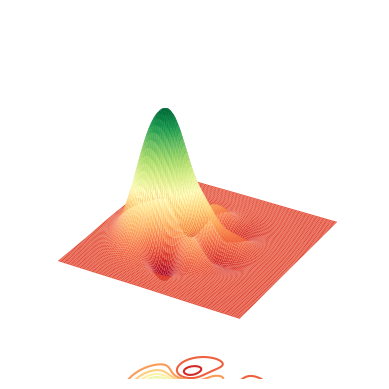

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
plt.savefig("T.png")
fig.show()

Learn

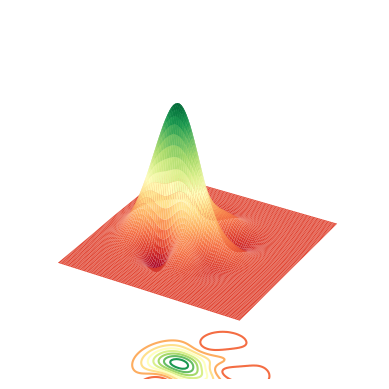

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="RdYlGn", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="RdYlGn", linestyles="solid", offset=-0.17)
ax.set_axis_off()
plt.savefig("L.png")
fig.show()